In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import copy

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
from torchsummary import summary
import torch_scatter

from rdkit import Chem
from rdkit.Chem import Descriptors, rdmolops

from sklearn.model_selection import train_test_split

# Start Here

In [2]:
class LigandDataset():
    def __init__(self, atom_list, natom_list, edge_index_list, edge_feats_list, y_list, denticities_list, smiles_list):
        self.atom_list = atom_list
        self.natom_list = natom_list
        self.edge_index_list = edge_index_list
        self.edge_feats_list = edge_feats_list
        self.y_list = y_list
        self.denticities_list = denticities_list
        self.smiles_list = smiles_list
        
    def __len__(self):
        return len(self.atom_list)
        
    def __getitem__(self, idx):
        return Data(x=torch.Tensor(self.atom_list[idx]),
                    natoms=torch.Tensor([self.natom_list[idx]]),
                    edge_index=torch.Tensor(np.array(self.edge_index_list[idx])),
                    edge_attr=torch.Tensor(self.edge_feats_list[idx]),
                    y=torch.Tensor(self.y_list[idx]).unsqueeze(1).to(torch.long),
                    denticity=torch.Tensor([self.denticities_list[idx]]),
                    smiles=self.smiles_list[idx]
                    # y=torch.nn.functional.one_hot(torch.Tensor(self.y_list[idx]).to(torch.long), num_classes=2) # one-hot
                   )

train_data = torch.load('data/train_dataset.pt')
test_data = torch.load('data/test_dataset.pt')
val_data = torch.load('data/val_dataset.pt')

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

In [3]:
train_data[0].natoms, train_data[0].smiles, train_data[0].y

(tensor([13.]),
 'CC(C)(C)C(=[N-])/C=C(\\[N-2])C(C)(C)C',
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0]]))

In [4]:
def compute_batch_loss(preds: torch.Tensor, labels: torch.Tensor, inds: torch.Tensor):
    """ 
    Computes a cross-entropy loss for each atom.
    Then, computes the mean of that loss for each ligand, and then across all ligands in the batch
    Parameters
    ----------
    preds : torch.Tensor (N,1)
        Atom-wise predicted logits for not-being or being a coordinating atom
    labels : torch.Tensor (N,1)
        Atom-wise labels for whether it isn't or is a coordinating atom
    inds : torch.Tensor (batch_size+1)
        The indices defining the ligands within each batch. Uses the batch.ptr generated by the torch_geometric dataloader.
    Return
    ------
    torch.Tensor (1,)
        Mean batch loss
    """
    # this is (N,2) for some reason
    loss_per_node = torch.nn.functional.binary_cross_entropy(preds, labels, reduction='none',
                                                             weight=torch.Tensor([1]).to(0))
    # Compute the mean cross-entropy across each individual graph, then the mean across the entire batch
    # graph_sizes = torch.diff(inds)
    # segment_ids = torch.repeat_interleave(torch.arange(len(graph_sizes), device=preds.device), graph_sizes)
    # graph_losses = torch_scatter.scatter_mean(loss_per_node, segment_ids, dim=0)
    # return graph_losses.mean()
    
    # Experimenting with averaging negative and positive losses
    # Note: this does not average over graphs
    # neg_loss = loss_per_node[labels[:,0].nonzero()]
    # pos_loss = loss_per_node[labels[:,1].nonzero()]
    # return neg_loss.mean() + pos_loss.mean()
    
    ## Average negative and positive losses separately per graph
    graph_sizes = torch.diff(inds)
    # Get how many ones/zeros are in each individual graph
    num_ones_per_graph = torch.Tensor([len(labels[inds[i-1]:inds[i]].nonzero()) for i in range(1,len(inds))],
                                     ).to(torch.long)
    num_zeros_per_graph = torch.Tensor([len(torch.where(labels[inds[i-1]:inds[i]]==0)[0]) for i in range(1,len(inds))],
                                     ).to(torch.long)
    ones_seg_ids = torch.repeat_interleave(torch.arange(len(num_ones_per_graph)), num_ones_per_graph).to(preds.device)
    zeros_seg_ids = torch.repeat_interleave(torch.arange(len(num_zeros_per_graph)), num_zeros_per_graph).to(preds.device)
    # compute mean loss for each pos/neg for each graph
    pos_loss = torch_scatter.scatter_mean(loss_per_node[labels.flatten().nonzero().flatten()], ones_seg_ids, dim=0)
    neg_loss = torch_scatter.scatter_mean(loss_per_node[torch.where(labels==0)[0]], zeros_seg_ids, dim=0)
    combined_loss_per_graph = pos_loss + neg_loss # element-wise for each graph

    # pred_num_one = torch_scatter.scatter_add(loss_per_node[labels.flatten().nonzero().flatten()], ones_seg_ids, dim=0)
    # pred_num_zero = torch_scatter.scatter_add(loss_per_node[torch.where(labels==0)[0]], zeros_seg_ids, dim=0)
    
    return (combined_loss_per_graph.mean())
            # + 0.5*torch.mean(torch.square(pred_num_one/denticities - 1))
            # + 0.01*torch.mean(torch.square(pred_num_zero/(natoms-denticities))))


In [5]:
def predict(model, batch, device):
    """ Predice node-wise probabilities of being a coordinating atom given a batch. """
    model.to(device)
    
    batch = batch.to(device)
    
    out_logits = model(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
    out_probs = torch.nn.functional.sigmoid(out_logits)
    return out_probs

def run_train(model, num_epochs, optimizer, scheduler, device):
    model.to(device)

    train_epoch_losses = []
    val_epoch_losses = []

    best_loss = 10000
    # Training Loop
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        model.train()
        for i, batch in enumerate(train_loader):
            batch = batch.to(device)

            out_logits = model(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
            # Switch to probabilities for the loss function
            out_probs = torch.nn.functional.sigmoid(out_logits)
            loss = compute_batch_loss(out_probs, batch.y.to(torch.float32), batch.ptr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        scheduler.step()

        epoch_train_loss = epoch_train_loss / (i+1)
        train_epoch_losses.append(epoch_train_loss)

        # Validation
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                batch = batch.to(device)
                out_logits = model(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
                out_probs = torch.nn.functional.sigmoid(out_logits)
                loss = compute_batch_loss(out_probs, batch.y.to(torch.float32), batch.ptr)
                epoch_val_loss += loss.item()
        epoch_val_loss = epoch_val_loss / (i+1)
        val_epoch_losses.append(epoch_val_loss)

        print(f'{model.__class__.__name__} | Epoch: {epoch+1} | Avg Train Loss: {epoch_train_loss:.3} | Avg Val Loss: {epoch_val_loss:.3}')

        # Early stopping
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
            patience = 5  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                break

        # Load the best model weights
        model.load_state_dict(best_model_weights)
    return epoch, train_epoch_losses, val_epoch_losses

## GAT

In [6]:
gat = torch_geometric.nn.GAT(-1, 20, num_layers=2, out_channels=1, dropout=0.5)
optimizer = torch.optim.Adam(gat.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 20

# what is the loss if we predict 0s for everything
pred_0_loss_val = 0
pred_opp_loss_val = 0
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch.to(device)
        out_probs = torch.zeros(batch.y.shape, dtype=torch.float64).to(device)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)
        pred_0_loss_val += loss.item()
pred_0_loss_val = pred_0_loss_val / (i+1)

# What is the loss if we predict the opposite for everything
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch.to(device)
        out_probs = 1-batch.y.to(torch.float64).to(device)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)
        pred_opp_loss_val += loss.item()
pred_opp_loss_val = pred_opp_loss_val / (i+1)
print(f'[BENCHMARK] Val Loss for all 0 predictions: {pred_0_loss_val:.3}')
print(f'[BENCHMARK] Val Loss for opposite predictions: {pred_opp_loss_val:.3}')

final_epoch, train_epoch_losses, val_epoch_losses = run_train(gat, num_epochs, optimizer, scheduler, device)

[BENCHMARK] Val Loss for all 0 predictions: 1e+02
[BENCHMARK] Val Loss for opposite predictions: 2e+02
GAT | Epoch: 1 | Avg Train Loss: 1.22 | Avg Val Loss: 0.86


KeyboardInterrupt: 

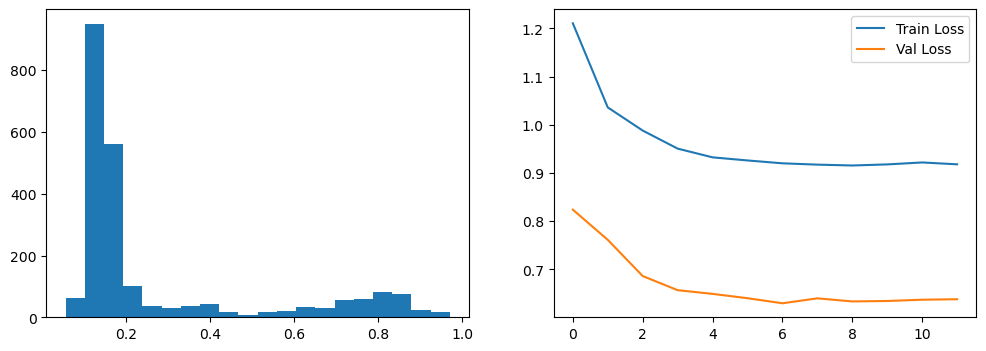

In [8]:
batch = next(iter(val_loader))
out_probs = predict(gat, batch, device)

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(out_probs.detach().cpu().numpy(), 20)

axs[1].plot(range(final_epoch+1), train_epoch_losses, label='Train Loss')
axs[1].plot(range(final_epoch+1), val_epoch_losses, label='Val Loss')
plt.legend()
plt.show()

## GCN

In [9]:
gcn = torch_geometric.nn.GCN(-1, 10, num_layers=2, out_channels=1, dropout=0.5)
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20

final_epoch, train_epoch_losses, val_epoch_losses = run_train(gcn, num_epochs, optimizer, scheduler, device)

GCN | Epoch: 1 | Avg Train Loss: 1.26 | Avg Val Loss: 1.11
GCN | Epoch: 2 | Avg Train Loss: 1.07 | Avg Val Loss: 0.948
GCN | Epoch: 3 | Avg Train Loss: 0.948 | Avg Val Loss: 0.842
GCN | Epoch: 4 | Avg Train Loss: 0.871 | Avg Val Loss: 0.787
GCN | Epoch: 5 | Avg Train Loss: 0.832 | Avg Val Loss: 0.755
GCN | Epoch: 6 | Avg Train Loss: 0.809 | Avg Val Loss: 0.733
GCN | Epoch: 7 | Avg Train Loss: 0.791 | Avg Val Loss: 0.72
GCN | Epoch: 8 | Avg Train Loss: 0.78 | Avg Val Loss: 0.709
GCN | Epoch: 9 | Avg Train Loss: 0.772 | Avg Val Loss: 0.702
GCN | Epoch: 10 | Avg Train Loss: 0.764 | Avg Val Loss: 0.694
GCN | Epoch: 11 | Avg Train Loss: 0.762 | Avg Val Loss: 0.689
GCN | Epoch: 12 | Avg Train Loss: 0.756 | Avg Val Loss: 0.686
GCN | Epoch: 13 | Avg Train Loss: 0.752 | Avg Val Loss: 0.682
GCN | Epoch: 14 | Avg Train Loss: 0.751 | Avg Val Loss: 0.68
GCN | Epoch: 15 | Avg Train Loss: 0.748 | Avg Val Loss: 0.678
GCN | Epoch: 16 | Avg Train Loss: 0.746 | Avg Val Loss: 0.677
GCN | Epoch: 17 | Avg T

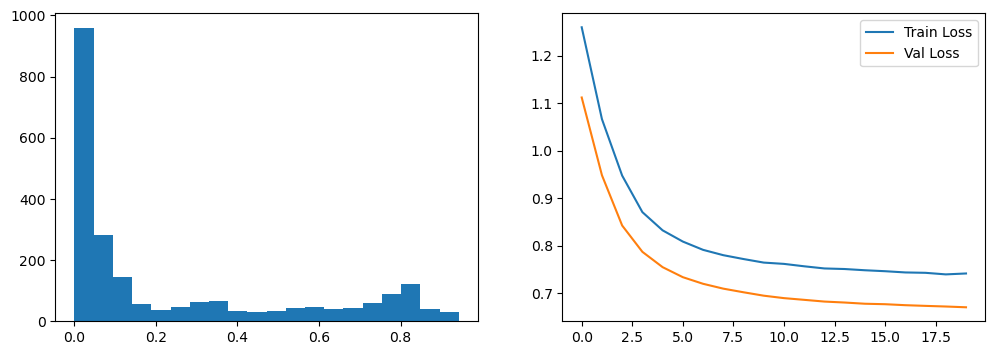

In [10]:
batch = next(iter(val_loader))
out_probs = predict(gcn, batch, device)

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(out_probs.detach().cpu().numpy(), 20)

axs[1].plot(range(final_epoch+1), train_epoch_losses, label='Train Loss')
axs[1].plot(range(final_epoch+1), val_epoch_losses, label='Val Loss')
plt.legend()
plt.show()

In [9]:
# Test Loss
gat.eval()
test_loss = 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(0)
        out_logits = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float32), batch.ptr)
        test_loss += loss.item()
    test_loss /= (i+1)
print(f'Test Loss: {test_loss}')

Test Loss: 0.8008538877710383


In [94]:
summary(gat)

Layer (type:depth-idx)                   Param #
├─ReLU: 1-1                              --
├─ModuleList: 1-2                        --
|    └─GATConv: 2-1                      --
|    |    └─SumAggregation: 3-1          --
|    |    └─Linear: 3-2                  20
|    └─GATConv: 2-2                      --
|    |    └─SumAggregation: 3-3          --
|    |    └─Linear: 3-4                  4
Total params: 24
Trainable params: 24
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ReLU: 1-1                              --
├─ModuleList: 1-2                        --
|    └─GATConv: 2-1                      --
|    |    └─SumAggregation: 3-1          --
|    |    └─Linear: 3-2                  20
|    └─GATConv: 2-2                      --
|    |    └─SumAggregation: 3-3          --
|    |    └─Linear: 3-4                  4
Total params: 24
Trainable params: 24
Non-trainable params: 0

## Hyperparam Optimization

In [32]:
gat_hyperparams = np.load('data/opts/sweep_gcn.npz')
print(list(gat_hyperparams.keys()))

['hc_list', 'nl_list', 'do_list', 'act_list', 'loss_list', 'epoch_list']


In [33]:
best_idx = np.argmin(gat_hyperparams['loss_list'])

In [34]:
best_hc = gat_hyperparams['hc_list'][best_idx]
best_nl = gat_hyperparams['nl_list'][best_idx]
best_do = gat_hyperparams['do_list'][best_idx]
best_act = gat_hyperparams['act_list'][best_idx]

In [35]:
best_hc, best_nl, best_do, best_act

(10.0, 2.0, 0.5, 'relu')

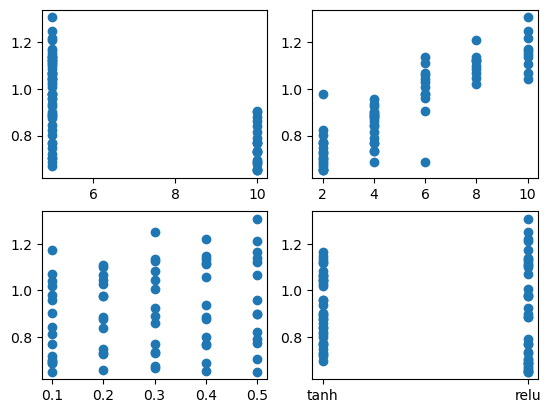

In [36]:
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(gat_hyperparams['hc_list'], gat_hyperparams['loss_list'])
axs[0,1].scatter(gat_hyperparams['nl_list'], gat_hyperparams['loss_list'])
axs[1,0].scatter(gat_hyperparams['do_list'], gat_hyperparams['loss_list'])
axs[1,1].scatter(gat_hyperparams['act_list'], gat_hyperparams['loss_list'])